In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

train_batch_size = 100
test_batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
temp = torch.tensor(np.random.randint(0, 10, (len(trainset),)))
trainset.targets = temp.tolist()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 4 * 4, 120)  
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.bn1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.bn2(x)
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = self.bn3(x)
        x = x.view(-1, 64 * 4 * 4)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [3]:
def train_and_evaluate_model(model, train_loader, test_loader, optimizer, criterion, epochs=100):
    model.train()
    train_losses, test_losses = [], []

    for epoch in range(epochs):
        total_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_test_loss = 0.0
        total_correct = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                total_test_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1, keepdim=True)
                total_correct += preds.eq(labels.view_as(preds)).sum().item()

        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        accuracy = total_correct / len(test_loader.dataset)

        print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.4f}')

    return train_losses, test_losses

In [4]:
model = CNN_Model()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses = train_and_evaluate_model(model, trainloader, testloader, optimizer, loss_func)

Epoch 1, Train Loss: 2.3178, Test Loss: 2.3064, Accuracy: 0.0947
Epoch 2, Train Loss: 2.3023, Test Loss: 2.3088, Accuracy: 0.0672
Epoch 3, Train Loss: 2.2991, Test Loss: 2.3185, Accuracy: 0.0896
Epoch 4, Train Loss: 2.2928, Test Loss: 2.2889, Accuracy: 0.1398
Epoch 5, Train Loss: 2.2786, Test Loss: 2.3270, Accuracy: 0.0875
Epoch 6, Train Loss: 2.2480, Test Loss: 2.3351, Accuracy: 0.1091
Epoch 7, Train Loss: 2.1870, Test Loss: 2.4144, Accuracy: 0.0966
Epoch 8, Train Loss: 2.0882, Test Loss: 2.5225, Accuracy: 0.1000
Epoch 9, Train Loss: 1.9669, Test Loss: 2.6141, Accuracy: 0.0924
Epoch 10, Train Loss: 1.8261, Test Loss: 2.7507, Accuracy: 0.1010
Epoch 11, Train Loss: 1.6946, Test Loss: 3.0557, Accuracy: 0.0943
Epoch 12, Train Loss: 1.5640, Test Loss: 3.2466, Accuracy: 0.0978
Epoch 13, Train Loss: 1.4490, Test Loss: 3.5869, Accuracy: 0.0971
Epoch 14, Train Loss: 1.3506, Test Loss: 3.8066, Accuracy: 0.0917
Epoch 15, Train Loss: 1.2661, Test Loss: 4.0806, Accuracy: 0.0943
Epoch 16, Train Los

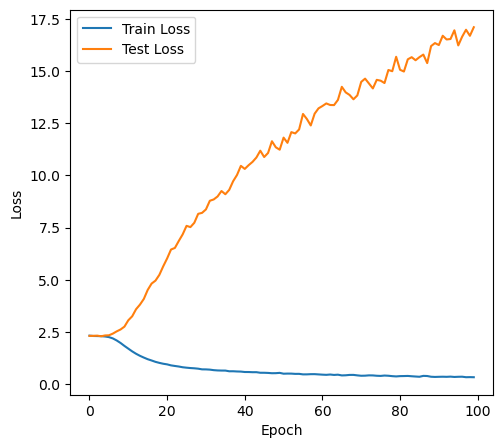

In [7]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()